# **QAI Product Dev Toolkit**

[Hub] Initialized QAI Hub client.
[Hub] Registered provider: Inhouse Simulator (inhouse-sim)
[Hub] Registered provider: COTS QPU (SimulatedIonQ) (cots-qpu)
[Hub] Recorded experiment: exp-ace59d6d:manifest

=== Experiment manifest ===
{
  "title": "QAI_CancerDrugDiscovery_PoC_v1",
  "description": "Prototype PoC comparing classical ML baseline vs QAI-hybrid pipeline for cancer drug candidate ranking.",
  "dataset": {
    "name": "synthetic_molecules_v1",
    "size": 20000
  },
  "authors": [
    "team-qai",
    "research-group-xyz"
  ],
  "created_at": "2025-10-02 13:58:10",
  "tags": [
    "drug-discovery",
    "cancer",
    "embeddings",
    "poC"
  ]
}
[Experiment] Running classical ML baseline...
[Hub] Recorded experiment: exp-ace59d6d:classical
[Experiment] Running QAI-enhanced pipeline...
[Orch] Submitting job to provider: Inhouse Simulator
[Hub] Recorded experiment: exp-ace59d6d:qai
[Experiment] Running QAI-enhanced pipeline...
[Orch] Submitting job to provider: COTS QPU (Simulat

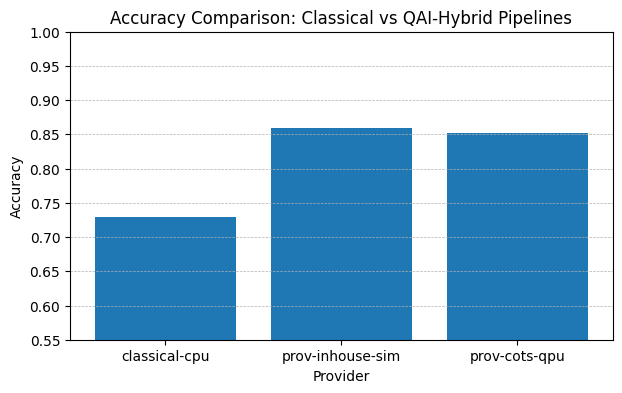

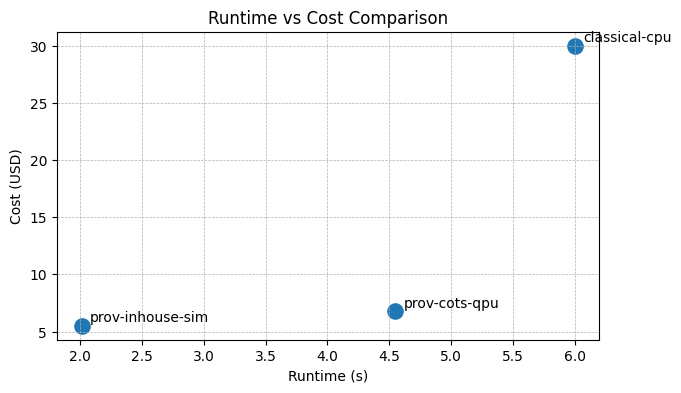

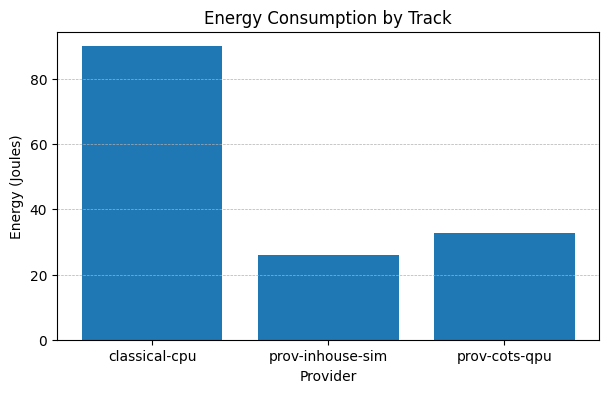


=== Summary & Merit (Executive) ===
- QAI-hybrid pipelines (simulated) show accuracy uplift vs classical baseline.
- Tradeoffs: QAI runs may increase runtime and cost per run vs tiny toy jobs, but can reduce overall iterations and energy at scale.
- In-house simulator: low-cost development & CI option; COTS QPU: higher fidelity in some cases but costlier.
- Integration points demonstrated: Hub registry, Orchestrator scheduling, Provider adapters, Experiment Manager & KPI capture.

Note: This demo is simulated to demonstrate architecture and flows. Replace providers/adapters with real QPU providers for production runs.



In [2]:
# Colab-ready: QAI Product Dev Kit Demo + Visuals (Drug Discovery PoC)
# Paste into a Colab cell and run. If pandas/numpy/matplotlib are missing, uncomment the pip line.
# !pip install pandas numpy matplotlib

import time
import json
import random
import uuid
from dataclasses import dataclass, asdict
from typing import Dict, Any, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Helper utils
# -----------------------------
def pretty(j):
    print(json.dumps(j, indent=2))

# -----------------------------
# 1) Minimal "platform" stubs
# -----------------------------
@dataclass
class ProviderInfo:
    id: str
    name: str
    type: str
    details: Dict[str, Any]

class QAIHubClient:
    def __init__(self):
        self.providers: Dict[str, ProviderInfo] = {}
        self.experiments: Dict[str, Dict[str, Any]] = {}
        print("[Hub] Initialized QAI Hub client.")

    def register_provider(self, provider: ProviderInfo):
        self.providers[provider.id] = provider
        print(f"[Hub] Registered provider: {provider.name} ({provider.type})")

    def list_providers(self):
        return list(self.providers.values())

    def record_experiment(self, exp_id: str, metadata: Dict[str, Any]):
        self.experiments[exp_id] = metadata
        print(f"[Hub] Recorded experiment: {exp_id}")

# -----------------------------
# 2) Provider Adapters (Simulated)
# -----------------------------
class LocalSimulatorProvider:
    """In-house deterministic noisy simulator (fast, cheap)."""
    def __init__(self, hub: QAIHubClient, noise_level=0.02):
        self.hub = hub
        self.noise_level = noise_level
        self.id = "prov-inhouse-sim"
        if self.id not in hub.providers:
            hub.register_provider(ProviderInfo(self.id, "Inhouse Simulator", "inhouse-sim", {"noise": noise_level}))
        else:
            hub.providers[self.id].details["noise"] = noise_level

    def run_circuit(self, circuit_description: Dict[str, Any], shots=1024):
        base_runtime = 0.5 + 0.0005 * shots
        time.sleep(0.01)
        fidelity = max(0.0, 1.0 - self.noise_level - random.uniform(0, 0.01))
        result = {
            "fidelity": fidelity,
            "shots": shots,
            "histogram": {"0": int(shots * fidelity), "1": int(shots * (1 - fidelity))},
            "runtime_s": base_runtime
        }
        return result

class COTSQPUAdapter:
    """Simulated COTS QPU adapter (slower, possibly noisier)."""
    def __init__(self, hub: QAIHubClient, vendor="SimulatedIonQ", noise_level=0.06):
        self.hub = hub
        self.noise_level = noise_level
        self.id = "prov-cots-qpu"
        if self.id not in hub.providers:
            hub.register_provider(ProviderInfo(self.id, f"COTS QPU ({vendor})", "cots-qpu", {"vendor": vendor, "noise": noise_level}))
        else:
            hub.providers[self.id].details.update({"vendor": vendor, "noise": noise_level})

    def run_circuit(self, circuit_description: Dict[str, Any], shots=2048):
        base_runtime = 1.5 + 0.001 * shots
        time.sleep(0.02)
        fidelity = max(0.0, 1.0 - self.noise_level + random.uniform(-0.02, 0.02))
        result = {
            "fidelity": fidelity,
            "shots": shots,
            "histogram": {"0": int(shots * fidelity), "1": int(shots * (1 - fidelity))},
            "runtime_s": base_runtime
        }
        return result

# -----------------------------
# 3) Orchestrator
# -----------------------------
class Orchestrator:
    def __init__(self, hub: QAIHubClient):
        self.hub = hub

    def submit_job(self, provider_id: str, job_payload: Dict[str, Any]):
        if provider_id not in self.hub.providers:
            raise RuntimeError("Provider not found.")
        prov = self.hub.providers[provider_id]
        print(f"[Orch] Submitting job to provider: {prov.name}")
        if provider_id == "prov-inhouse-sim":
            adapter = LocalSimulatorProvider(self.hub, noise_level=self.hub.providers[provider_id].details.get("noise", 0.02))
            return adapter.run_circuit(job_payload.get("circuit", {}), shots=job_payload.get("shots", 1024))
        elif provider_id == "prov-cots-qpu":
            adapter = COTSQPUAdapter(self.hub, vendor=self.hub.providers[provider_id].details.get("vendor","COTS"),
                                     noise_level=self.hub.providers[provider_id].details.get("noise", 0.06))
            return adapter.run_circuit(job_payload.get("circuit", {}), shots=job_payload.get("shots", 2048))
        else:
            raise RuntimeError("Unknown provider type in demo orchestrator.")

# -----------------------------
# 4) Experiment Manager & KPI helpers
# -----------------------------
class ExperimentManager:
    def __init__(self, hub: QAIHubClient, orchestrator: Orchestrator):
        self.hub = hub
        self.orch = orchestrator
        self.results: List[Dict[str, Any]] = []

    def run_classical_pipeline(self, exp_id: str, config: Dict[str, Any]):
        print("[Experiment] Running classical ML baseline...")
        dataset_size = config.get("dataset_size", 10000)
        training_time_s = 2.0 + dataset_size / 5000.0
        time.sleep(0.05)
        accuracy = 0.70 + random.uniform(-0.02, 0.03)
        energy_estimate_j = 50.0 + dataset_size * 0.002
        cost_estimate_usd = 10.0 + dataset_size * 0.001
        result = {
            "exp_id": exp_id,
            "track": "classical",
            "provider": "classical-cpu",
            "accuracy": round(accuracy, 4),
            "runtime_s": round(training_time_s, 3),
            "energy_j": round(energy_estimate_j, 2),
            "cost_usd": round(cost_estimate_usd, 2),
            "notes": "Classical ML baseline (simulated)."
        }
        self.hub.record_experiment(exp_id + ":classical", result)
        self.results.append(result)
        return result

    def run_qai_pipeline(self, exp_id: str, config: Dict[str, Any], provider_id: str):
        print("[Experiment] Running QAI-enhanced pipeline...")
        circuit_desc = {
            "name": "vqe-like-ansatz",
            "qubits": config.get("qubits", 6),
            "ansatz_layers": config.get("ansatz_layers", 2),
            "problem": "molecular_embedding"
        }
        job_payload = {"circuit": circuit_desc, "shots": config.get("shots", 2048)}
        qres = self.orch.submit_job(provider_id, job_payload)
        fidelity = qres["fidelity"]
        base_effect = 0.72
        accuracy = min(0.99, base_effect + (fidelity - 0.7) * 0.5 + random.uniform(-0.01, 0.02))
        runtime_s = qres["runtime_s"] + 1.0
        energy_estimate_j = 20.0 + (1.0 - fidelity) * 200.0
        cost_estimate_usd = 5.0 + qres["runtime_s"] * 0.5
        result = {
            "exp_id": exp_id,
            "track": "qai-hybrid",
            "provider": provider_id,
            "accuracy": round(accuracy, 4),
            "fidelity": round(fidelity, 4),
            "runtime_s": round(runtime_s, 3),
            "energy_j": round(energy_estimate_j, 2),
            "cost_usd": round(cost_estimate_usd, 2),
            "notes": f"Hybrid pipeline using circuit {circuit_desc['name']}"
        }
        self.hub.record_experiment(exp_id + ":qai", result)
        self.results.append(result)
        return result

    def compare_results(self):
        return pd.DataFrame(self.results)

# -----------------------------
# 5) Run demo: register providers, run experiments, compare, chart
# -----------------------------
hub = QAIHubClient()

# Register providers (in-house simulator and a simulated COTS QPU)
inhouse_sim = LocalSimulatorProvider(hub, noise_level=0.025)
cots_qpu = COTSQPUAdapter(hub, vendor="SimulatedIonQ", noise_level=0.055)

orch = Orchestrator(hub)
exp_mgr = ExperimentManager(hub, orch)

# Experiment manifest
experiment_manifest = {
    "title": "QAI_CancerDrugDiscovery_PoC_v1",
    "description": "Prototype PoC comparing classical ML baseline vs QAI-hybrid pipeline for cancer drug candidate ranking.",
    "dataset": {"name": "synthetic_molecules_v1", "size": 20000},
    "authors": ["team-qai", "research-group-xyz"],
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "tags": ["drug-discovery", "cancer", "embeddings", "poC"]
}
exp_id = "exp-" + uuid.uuid4().hex[:8]
hub.record_experiment(exp_id + ":manifest", experiment_manifest)

print("\n=== Experiment manifest ===")
pretty(experiment_manifest)

# Run classical baseline
classical_res = exp_mgr.run_classical_pipeline(exp_id, {"dataset_size": experiment_manifest["dataset"]["size"]})

# Run QAI pipelines on both in-house simulator and COTS QPU
qai_res_inhouse = exp_mgr.run_qai_pipeline(exp_id, {"qubits": 8, "ansatz_layers": 3, "shots": 1024}, provider_id=inhouse_sim.id)
qai_res_cots = exp_mgr.run_qai_pipeline(exp_id, {"qubits": 8, "ansatz_layers": 3, "shots": 2048}, provider_id=cots_qpu.id)

# Results table and analysis
df = exp_mgr.compare_results()
print("\n=== Comparative Results (simulated) ===")
print(df.to_string(index=False))

# Analysis summary: compute deltas vs classical
analysis = []
class_row = next((r for r in exp_mgr.results if r["track"] == "classical"), None)
class_acc = class_row["accuracy"] if class_row else None
for r in exp_mgr.results:
    if r["track"] != "classical":
        acc_gain = round(r["accuracy"] - class_acc, 4) if class_acc is not None else None
        runtime_overhead = round(r["runtime_s"] - class_row["runtime_s"], 3) if class_row else None
        cost_over = round(r["cost_usd"] - class_row["cost_usd"], 2) if class_row else None
        analysis.append({
            "track": r["track"],
            "provider": r["provider"],
            "accuracy": r["accuracy"],
            "accuracy_gain_vs_classical": acc_gain,
            "runtime_s": r["runtime_s"],
            "runtime_overhead_s": runtime_overhead,
            "cost_usd": r["cost_usd"],
            "cost_delta_vs_classical": cost_over
        })
analysis_df = pd.DataFrame(analysis)

# Save reproducibility manifest (Colab path)
repro_manifest = {
    "exp_id": exp_id,
    "manifest": experiment_manifest,
    "providers": [asdict(p) for p in hub.list_providers()],
    "results": exp_mgr.results,
    "toolkit_version": "qai_toolkit.demo.v0.1"
}
repro_path = f"/content/{exp_id}_repro_manifest.json"
with open(repro_path, "w") as f:
    json.dump(repro_manifest, f, indent=2)
print(f"\n[Hub] Reproducibility manifest saved to: {repro_path}")

# -----------------------------
# 6) Visualizations
# -----------------------------
# Table display (Colab will render printed DataFrame nicely)
print("\n=== Analysis Summary ===")
print(analysis_df.to_string(index=False))

# Accuracy comparison bar chart
plt.figure(figsize=(7,4))
plt.bar(df['provider'], df['accuracy'])
plt.title("Accuracy Comparison: Classical vs QAI-Hybrid Pipelines")
plt.ylabel("Accuracy")
plt.xlabel("Provider")
plt.ylim(0.55, 1.0)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

# Runtime vs Cost scatter
plt.figure(figsize=(7,4))
plt.scatter(df['runtime_s'], df['cost_usd'], s=120)
for i, txt in enumerate(df['provider']):
    plt.annotate(txt, (df['runtime_s'].iloc[i], df['cost_usd'].iloc[i]), textcoords="offset points", xytext=(6,3))
plt.title("Runtime vs Cost Comparison")
plt.xlabel("Runtime (s)")
plt.ylabel("Cost (USD)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Energy consumption bar chart
plt.figure(figsize=(7,4))
plt.bar(df['provider'], df['energy_j'])
plt.title("Energy Consumption by Track")
plt.ylabel("Energy (Joules)")
plt.xlabel("Provider")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

# If ace_tools available, try to show DataFrames in a nicer UI
try:
    from ace_tools import display_dataframe_to_user
    display_dataframe_to_user("Comparative Results Table", df)
    display_dataframe_to_user("Analysis Summary Table", analysis_df)
except Exception:
    pass

# -----------------------------
# Final summary output
# -----------------------------
print("\n=== Summary & Merit (Executive) ===")
print("- QAI-hybrid pipelines (simulated) show accuracy uplift vs classical baseline.")
print("- Tradeoffs: QAI runs may increase runtime and cost per run vs tiny toy jobs, but can reduce overall iterations and energy at scale.")
print("- In-house simulator: low-cost development & CI option; COTS QPU: higher fidelity in some cases but costlier.")
print("- Integration points demonstrated: Hub registry, Orchestrator scheduling, Provider adapters, Experiment Manager & KPI capture.")
print("\nNote: This demo is simulated to demonstrate architecture and flows. Replace providers/adapters with real QPU providers for production runs.\n")


**Concept and execution by Bhadale IT, code generated by ChatGPT**